In [42]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf

# from mt2 import mt2

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [43]:
seed = 42  # set random seed
sampling = int(1e6)
# num_folds = 2
batch_size = 1024
epochs = 512
learning_rate = 1e-6

In [44]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=30)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 30

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [45]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [46]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)
lep_m = processor.process_part(data.LepM)
lep_kin = pd.concat([lep_p.iloc[:,:4], lep_m.iloc[:,:4]], axis=1)
MET = processor.process_MET(data.MET)
dilep_kin = processor.process_dipart(data.LepP, data.LepM)
# mt = np.sqrt(
#     mt2(
#         lep_m["m"],
#         lep_m["px"],
#         lep_m["py"],  # Visible 1: mass, px, py
#         lep_p["m"],
#         lep_p["px"],
#         lep_p["py"],  # Visible 2: mass, px, py
#         MET["MET_px"],
#         MET["MET_py"],  # Missing transverse momentum: x, y
#         0,
#         0,  # Invisible 1 mass, invisible 2 mass
#     )
# )
# vx = 5 * pd.DataFrame({"vx": mt + 0.3 * np.sqrt(dilep_kin["m"])})
# dilep_kin.iloc[:, 0:4]
obs_kin = pd.concat([MET.iloc[:, 1:3], lep_kin], axis=1)[cut_pre]
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(processor.process_dipart(data.NuP, data.NuM)[["pz"]])[cut_pre]
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET, dilep_kin)
gc.collect()

obs_kin shape: (1378510, 10)
       MET_px     MET_py           E         px         py          pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

            E         px         py         pz  
7   43.361348  42.407754  -4.632000   7.767462  
9   70.592648  29.001777   1.896990 -64.332027  
10  90.238664 -23.868604  32.986602  80.530680  

int_kin shape: (1378510, 1)
            pz
7  -105.565620
9  -170.813820
10   92.722389



/root/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


0

In [47]:
SCALAR_int_ru = RobustScaler()
int_kin = SCALAR_int_ru.fit_transform(int_kin)
SCALAR_int_mm = MinMaxScaler()
int_kin = SCALAR_int_mm.fit_transform(int_kin)

SCALAR_obs_ru = RobustScaler()
obs_kin = SCALAR_obs_ru.fit_transform(obs_kin)
SCALAR_obs_mm = MinMaxScaler()
obs_kin = SCALAR_obs_mm.fit_transform(obs_kin)

In [48]:
indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (551404, 10);
Validing data shape: (413553, 10);
Testing data shape: (413553, 10).
Y (Observed)
Training data shape: (551404, 1);
Validing data shape: (413553, 1);
Testing data shape: (413553, 1).



In [49]:
# Define a new activation function
def custom_activation(x):
    return x*tf.keras.backend.sigmoid(x)

# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)
    
    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="sigmoid")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [50]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 16)                176       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
 dense_3 (Dense)             (None, 4)                 20    

In [51]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512
2154/2154 - 11s - loss: 0.0017 - val_loss: 0.0013 - 11s/epoch - 5ms/step
Epoch 2/512
2154/2154 - 9s - loss: 0.0013 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 3/512
2154/2154 - 9s - loss: 0.0012 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 4/512
2154/2154 - 9s - loss: 0.0012 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 5/512
2154/2154 - 9s - loss: 0.0012 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 6/512
2154/2154 - 9s - loss: 0.0012 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 7/512
2154/2154 - 9s - loss: 0.0012 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 8/512
2154/2154 - 9s - loss: 0.0012 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 9/512
2154/2154 - 9s - loss: 0.0011 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 10/512
2154/2154 - 9s - loss: 0.0011 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 11/512
2154/2154 - 9s - loss: 0.0011 - val_loss: 0.0011 - 9s/epoch - 4ms/step
Epoch 12/512
2154/2154 - 9s - loss: 0.0011 - val_loss: 0.0010 - 9s/epoch - 4ms/step

In [52]:
# save model
model.save("./DNN_pz.h5", save_format="h5", overwrite=True)
# predict
pred_y = model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12924/12924 [==============================] - 15s 1ms/step


In [53]:
print(f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}")

Truth mean: 0.498, std: 0.033


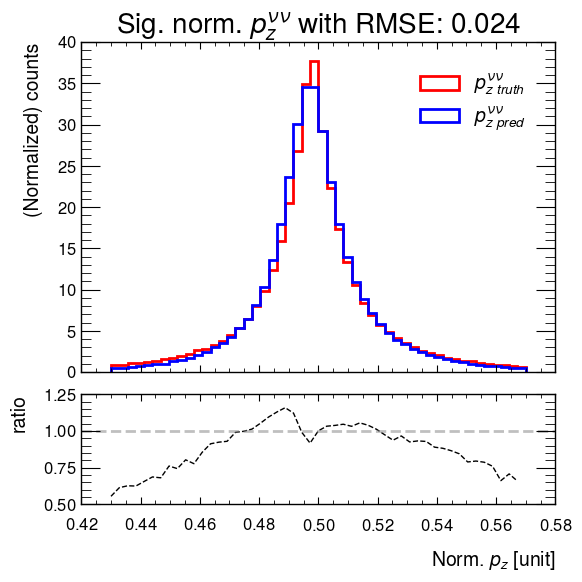

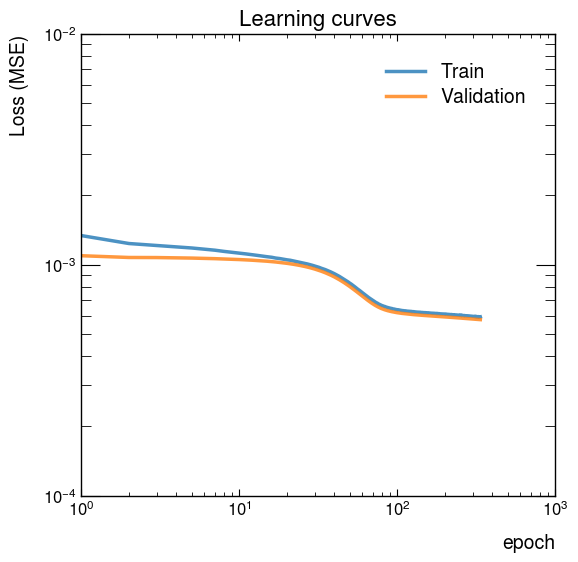

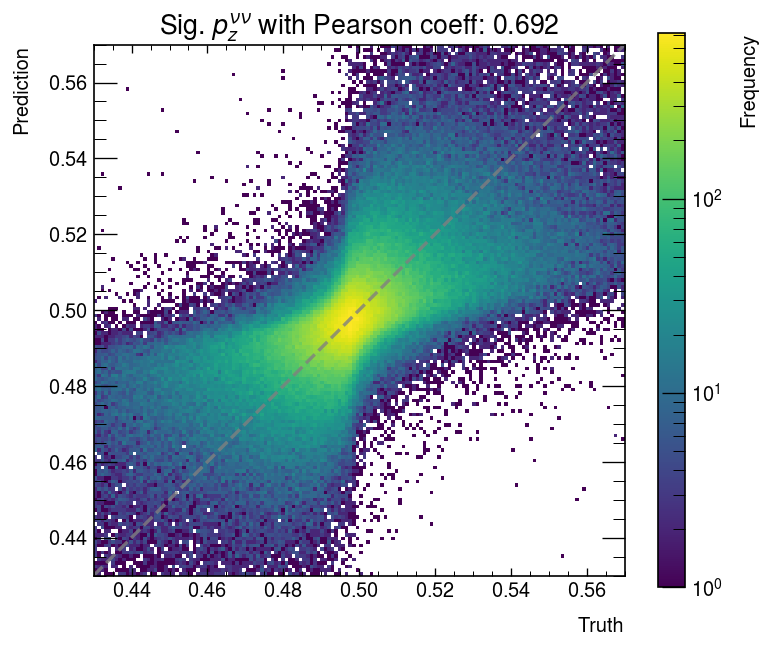

In [62]:
range = [0.43, 0.57]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Sig. norm. $p^{\nu\nu}_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    range=range,
    xlabel=r"Norm. $p_{z}$ [unit]",
)

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Sig. $p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)

# time_end = time()
# print(f"Time cost: {time_end - time_start:.2f} s")

In [55]:
# load bkg data
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=30)
path = "/root/data/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 30

['/root/data/truth/background/CGLMP.npz', '/root/data/truth/background/Higgs.npz', '/root/data/truth/background/LeadLepton.npz', '/root/data/truth/background/LeptonM.npz', '/root/data/truth/background/LeptonP.npz', '/root/data/truth/background/LmNu.npz', '/root/data/truth/background/LpNu.npz', '/root/data/truth/background/MET.npz', '/root/data/truth/background/WmBoson.npz', '/root/data/truth/background/WpBoson.npz', '/root/data/truth/background/diLepton.npz', '/root/data/truth/background/subLeadLepton.npz', '/root/data/truth/background/xi_xyz.npz']



In [56]:
cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [57]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)
lep_m = processor.process_part(data.LepM)
lep_kin = pd.concat([lep_p.iloc[:,:4], lep_m.iloc[:,:4]], axis=1)
MET = processor.process_MET(data.MET)
dilep_kin = processor.process_dipart(data.LepP, data.LepM)
# mt = np.sqrt(
#     mt2(
#         lep_m["m"],
#         lep_m["px"],
#         lep_m["py"],  # Visible 1: mass, px, py
#         lep_p["m"],
#         lep_p["px"],
#         lep_p["py"],  # Visible 2: mass, px, py
#         MET["MET_px"],
#         MET["MET_py"],  # Missing transverse momentum: x, y
#         0,
#         0,  # Invisible 1 mass, invisible 2 mass
#     )
# )
# vx = 5 * pd.DataFrame({"vx": mt + 0.3 * np.sqrt(dilep_kin["m"])})
# dilep_kin.iloc[:, 0:4]
bkg_obs_kin = pd.concat([MET.iloc[:, 1:3], lep_kin], axis=1)[cut_pre]
print("bkg_obs_kin shape:", bkg_obs_kin.shape)
print(bkg_obs_kin.head(3))
print()

# targets -> interested unknowns
bkg_int_kin = pd.DataFrame(processor.process_dipart(data.NuP, data.NuM)[["pz"]])[cut_pre]
print("bkg_int_kin shape:", bkg_int_kin.shape)
print(bkg_int_kin.head(3))
print()

# del (processor, lep_p, lep_m, MET, dilep_kin)
# gc.collect()

/root/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


bkg_obs_kin shape: (3695466, 10)
      MET_px     MET_py          E         px         py         pz  \
0  25.612463 -13.902201  74.467914 -40.960633   1.786365 -62.165145   
1 -18.282999 -60.946995  51.507348  25.584187  39.103633  21.664768   
2 -68.832969  42.431961  44.308730  -6.140227 -31.041615 -31.015609   

            E         px         py          pz  
0   39.850980   9.973058  17.088891   34.591867  
1  174.719250  -3.526821  29.727287  172.135578  
2  118.062672 -19.257135 -61.463059  -98.945688  

bkg_int_kin shape: (3695466, 1)
           pz
0 -317.188483
1  617.228600
2  -21.066279



/root/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [58]:
SCALAR_int_ru = RobustScaler()
bkg_int_kin = SCALAR_int_ru.fit_transform(bkg_int_kin)
SCALAR_int_mm = MinMaxScaler()
bkg_int_kin = SCALAR_int_mm.fit_transform(bkg_int_kin)

SCALAR_obs_ru = RobustScaler()
bkg_obs_kin = SCALAR_obs_ru.fit_transform(bkg_obs_kin)
SCALAR_obs_mm = MinMaxScaler()
bkg_obs_kin = SCALAR_obs_mm.fit_transform(bkg_obs_kin)

In [59]:
# load model
trained_model = tf.keras.models.load_model("./DNN_pz.h5")
# predict
pred_y = trained_model.predict(bkg_obs_kin)
bkg_pred = pred_y
bkg_truth = bkg_int_kin

115484/115484 [==============================] - 134s 1ms/step


In [60]:
print(f"Truth mean: {np.mean(bkg_truth[:,0]):.3f}, std: {np.std(bkg_truth[:,0]):.3f}")

Truth mean: 0.495, std: 0.054


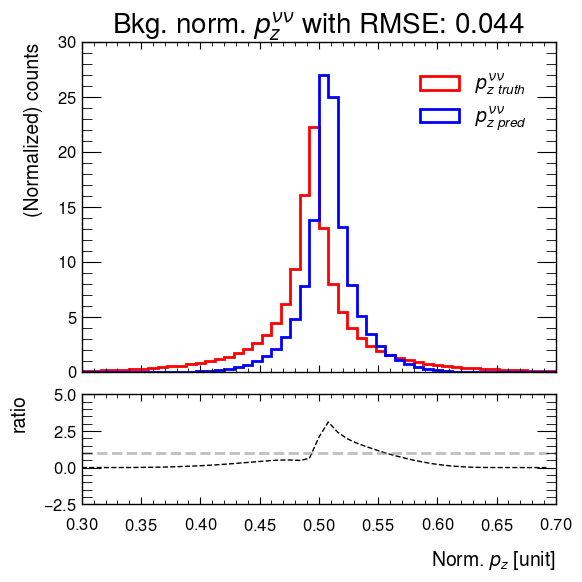

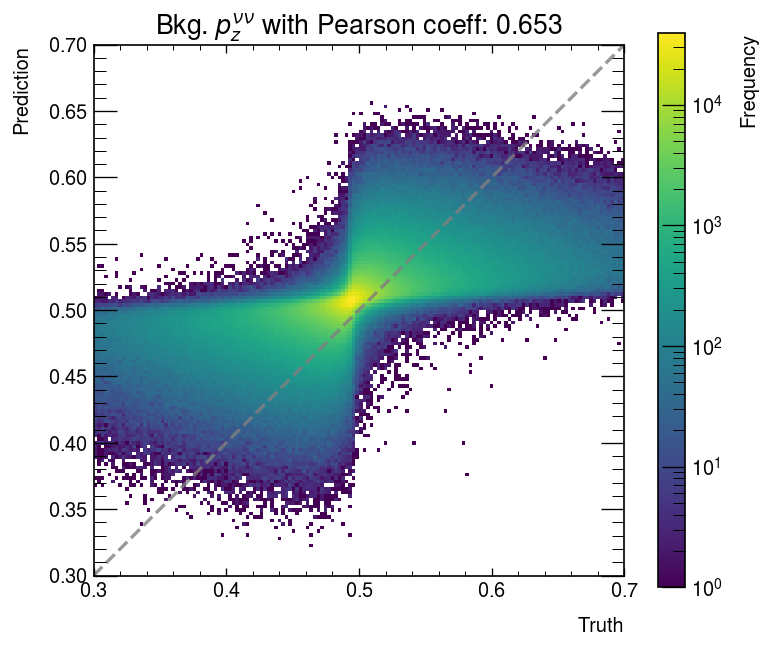

Time cost: 3327.44 s


In [61]:
range = [0.3, 0.7]

plot.plot_hist(
    [bkg_truth[:, 0], bkg_pred[:, 0]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Bkg. norm. $p^{\nu\nu}_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(bkg_truth[:,0], bkg_pred[:,0])):.3f}",
    range=range,
    xlabel=r"Norm. $p_{z}$ [unit]",
)

plot.plot_2d_histogram(
    bkg_truth[:, 0],
    bkg_pred[:, 0],
    r"Bkg. $p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,0], bkg_pred[:,0])[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {time_end - time_start:.2f} s")